In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from functools import total_ordering
from numpy.random import default_rng

#our classes!!! :)
from ParticleSim import Disk
from ParticleSim import Expt

In [2]:
# TEST CELL FOR showAnimation
seed = 42
rng = default_rng(seed=seed) # instatiate the default random number generator
sqrtNumParts = 2

pPosGrid = list(itertools.product(np.linspace(20, 180,sqrtNumParts), np.linspace(20,180,sqrtNumParts)))
pVelGrid = list(rng.random(size=(sqrtNumParts**2,2))*1) #slightly randomize initial velocities

particles = [Disk(pPosGrid[i], pVelGrid[i]) for i in range(sqrtNumParts**2)][:-1]

e1 = Expt(particles, dt=0.1, tmax=5, animSpeed=0.5)

print(e1.avgKE)
e1.showAnimation("seed = " + str(seed) + "     ")
print(e1.avgKE)

1.4879215759371183


MovieWriter ffmpeg unavailable; using Pillow instead.


bouta save animation...
[████████████████████████████████]   
finished animating!
281.98810703491085


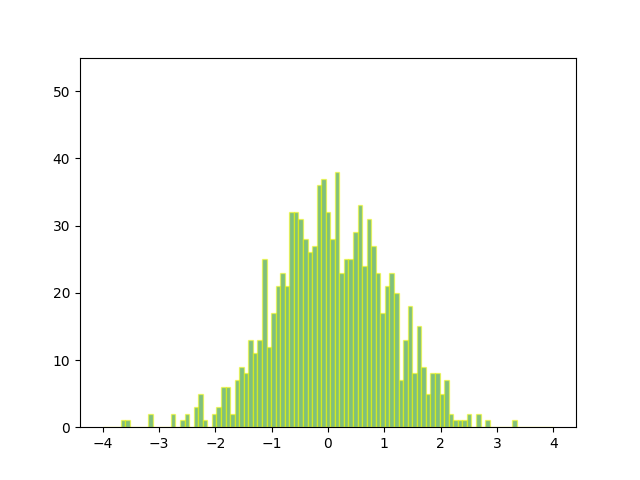

In [3]:
# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-4, 4, 100)

# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)
def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = np.random.randn(1000)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate
# Output generated via `matplotlib.animation.Animation.to_jshtml`.

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=55)  # set safe limit to ensure that all data is visible.

ani = FuncAnimation(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
plt.show()

In [ ]:
KEs = [2*x**2 for x in range(5)]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.hist(KEs, bins = 5, color = 'black', histtype = 'step', stacked = True);

In [ ]:
seed = 42
rng = default_rng(seed=seed) # instatiate the default random number generator
sqrtNumParts = 5

pPosGrid = list(itertools.product(np.linspace(20, 180,sqrtNumParts), np.linspace(20,180,sqrtNumParts)))
pVelGrid = list(rng.random(size=(sqrtNumParts**2,2))*1) #slightly randomize initial velocities

particles = [Disk(pPosGrid[i], pVelGrid[i]) for i in range(sqrtNumParts**2)][:-1]

e1 = Expt(particles, dt=0.1, tmax=15, animSpeed=0.5)

print(e1.avgKE)
e1.showAnimation("seed = " + str(seed) + "     ")
print(e1.avgKE)

In [ ]:
plt.close("all")

In [ ]:
#create and test an example disk
p = Disk([1,1], [6,8], 3, 2, 1)
p1 = Disk([3, 2], [3, 3], 1, 1, 1)

print(p < p1)
print(p == p1)
print(p > p1)
print(p.speed)
print(p.KE)
print(p.x)